# Эволюция сверточных сетей: AlexNet->EfficientNet (DL) 
    
# Домашнее задание
## Сравнение моделей

### Цель:
Сделать сравнительный анализ сверточных моделей для задачи классификации.


### Описание/Пошаговая инструкция выполнения домашнего задания:
Посчитать метрики качества на тестовых примерах и сделать сводную таблицу.

- Бонусные задания -- реализовать forward свертку, сделать демо с mobileNet.
Материалы ДЗ прикреплены, либо можете скачать их с colab: https://colab.research.google.com/drive/1rr1Xq2QGbXs4Epi8__sSJP5jr4Wr7Ysv?usp=sharing


## Задание 1 (базовое)
Построить аналогичный график accuracy top 5

<img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" width=600 height=300 />

 для различных моделей из Keras (можно на свой выбор) на примере датасета imagenette. Можете в целом использовать любой из тех, что есть в репозитории, но не забудьте указать какой. Валидация на части valid из датасета.

Более подробные графики с самыми последними результатами можно найти тут: paperwithcode: https://paperswithcode.com/sota/image-classification-on-imagenet.

В том числе можно попытаться воспользоваться реализацией FixEfficientNetV2: https://github.com/facebookresearch/FixRes, про которую мы на лекции не говорили, но она есть.

In [1]:
# Импорты
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import time
import numpy as np
import pandas as pd
import os
import pathlib

import tqdm

In [2]:
# функция возвращает device: gpu-cuda:0 или cpu
def get_device(device):
    device = device
    if device == 'gpu':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    else: device = torch.device('cpu')
    return device

In [3]:
# число эпох
num_epochs = 3

In [4]:
# Какие модели есть?
df_models = pd.read_html('https://pytorch.org/vision/stable/models.html')[1] #актуально на 27.04.2023 г.

df_models = pd.concat([df_models['Weight'].str.split('_Weights.', expand = True).rename(columns = {0: 'models', 1: 'Weights'}), 
                       df_models], axis = 1)
df_models['Params_float'] = df_models['Params'].str.replace('M', '').astype(float)

df_models

,models,Weights,Weight,Acc@1,Acc@5,Params,GFLOPS,Recipe,Params_float
0,AlexNet,IMAGENET1K_V1,AlexNet_Weights.IMAGENET1K_V1,56.522,79.066,61.1M,0.71,link,61.1
1,ConvNeXt_Base,IMAGENET1K_V1,ConvNeXt_Base_Weights.IMAGENET1K_V1,84.062,96.870,88.6M,15.36,link,88.6
2,ConvNeXt_Large,IMAGENET1K_V1,ConvNeXt_Large_Weights.IMAGENET1K_V1,84.414,96.976,197.8M,34.36,link,197.8
3,ConvNeXt_Small,IMAGENET1K_V1,ConvNeXt_Small_Weights.IMAGENET1K_V1,83.616,96.650,50.2M,8.68,link,50.2
4,ConvNeXt_Tiny,IMAGENET1K_V1,ConvNeXt_Tiny_Weights.IMAGENET1K_V1,82.520,96.146,28.6M,4.46,link,28.6
...,...,...,...,...,...,...,...,...,...
110,ViT_L_32,IMAGENET1K_V1,ViT_L_32_Weights.IMAGENET1K_V1,76.972,93.070,306.5M,15.38,link,306.5
111,Wide_ResNet101_2,IMAGENET1K_V1,Wide_ResNet101_2_Weights.IMAGENET1K_V1,78.848,94.284,126.9M,22.75,link,126.9
112,Wide_ResNet101_2,IMAGENET1K_V2,Wide_ResNet101_2_Weights.IMAGENET1K_V2,82.510,96.020,126.9M,22.75,link,126.9
113,Wide_ResNet50_2,IMAGENET1K_V1,Wide_ResNet50_2_Weights.IMAGENET1K_V1,78.468,94.086,68.9M,11.40,link,68.9


In [5]:
# Модели с числом парамером < 70М
df_models.loc[df_models['Params_float'] < 70]['models'].to_list()

['AlexNet',
 'ConvNeXt_Small',
 'ConvNeXt_Tiny',
 'DenseNet121',
 'DenseNet161',
 'DenseNet169',
 'DenseNet201',
 'EfficientNet_B0',
 'EfficientNet_B1',
 'EfficientNet_B1',
 'EfficientNet_B2',
 'EfficientNet_B3',
 'EfficientNet_B4',
 'EfficientNet_B5',
 'EfficientNet_B6',
 'EfficientNet_B7',
 'EfficientNet_V2_M',
 'EfficientNet_V2_S',
 'GoogLeNet',
 'Inception_V3',
 'MNASNet0_5',
 'MNASNet0_75',
 'MNASNet1_0',
 'MNASNet1_3',
 'MaxVit_T',
 'MobileNet_V2',
 'MobileNet_V2',
 'MobileNet_V3_Large',
 'MobileNet_V3_Large',
 'MobileNet_V3_Small',
 'RegNet_X_16GF',
 'RegNet_X_16GF',
 'RegNet_X_1_6GF',
 'RegNet_X_1_6GF',
 'RegNet_X_3_2GF',
 'RegNet_X_3_2GF',
 'RegNet_X_400MF',
 'RegNet_X_400MF',
 'RegNet_X_800MF',
 'RegNet_X_800MF',
 'RegNet_X_8GF',
 'RegNet_X_8GF',
 'RegNet_Y_1_6GF',
 'RegNet_Y_1_6GF',
 'RegNet_Y_3_2GF',
 'RegNet_Y_3_2GF',
 'RegNet_Y_400MF',
 'RegNet_Y_400MF',
 'RegNet_Y_800MF',
 'RegNet_Y_800MF',
 'RegNet_Y_8GF',
 'RegNet_Y_8GF',
 'ResNeXt50_32X4D',
 'ResNeXt50_32X4D',
 'ResNe

In [6]:
# дата-фрейм для аккумулирования результатов качества
df_loss_models= pd.DataFrame()

In [7]:
# дата-фрейм для аккумулирования результатов
df = pd.DataFrame(index = ['vgg16', 'inception_v3', 'resnet50', 'mobilenet', 'efficientnet'])
df['params'] = np.NaN
df['top_5'] = np.NaN
df

,params,top_5
vgg16,NaN,NaN
inception_v3,NaN,NaN
resnet50,NaN,NaN
mobilenet,NaN,NaN
efficientnet,NaN,NaN


### скачаю дата-сет: https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

Код задает два набора преобразований для изображений: train и valid. 

Для train преобразования включают:
- RandomResizedCrop - случайное обрезание изображения с масштабированием в заданном диапазоне и размером 256 пикселей или 299 пикселей.
- RandomHorizontalFlip - случайное отражение изображения по горизонтали.
- RandomRotation - случайное поворот изображения на угол до 25 градусов.
- CenterCrop - вырезание центральной части изображения размером 224 пикселя или 299 пикселей.
- ToTensor - конвертация изображения в тензор.
- Normalize - нормализация значений тензора с помощью заданных параметров среднего и стандартного отклонения для каждого канала.

Для valid преобразования включают:
- Resize - изменение размера изображения до 256 пикселей или 299 пикселей.
- CenterCrop - вырезание центральной части изображения размером 224 пикселя.
- ToTensor - конвертация изображения в тензор.
- Normalize - нормализация значений тензора с помощью заданных параметров среднего и стандартного отклонения для каждого канала.

Оба набора преобразований используют одинаковые параметры нормализации, что помогает улучшить обучение модели.

- transforms.Normalize применяется для нормализации значений тензора с помощью заданных параметров среднего и стандартного отклонения для каждого канала.

In [8]:
image_transforms_1 = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(degrees=25),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [9]:
image_transforms_2 = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                          
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]),
    'valid': transforms.Compose([
       transforms.Resize((299, 299)),
       transforms.ToTensor(),                          
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]),
}

Функция train_valid для обучения и проверки нейронной сети. Функция принимает четыре аргумента: model - модель нейронной сети, которую нужно обучить; loss_criterion - функция потерь, используемая для оптимизации; optimizer - оптимизатор, используемый для оптимизации; и epochs - количество эпох для обучения модели.

Внутри функции код инициализирует некоторые переменные, включая history, best_loss и best_epoch. Затем он запускает цикл for для заданного количества эпох. В каждой эпохе он устанавливает модель в режим обучения и инициализирует переменные train_loss и train_acc. Он перебирает обучающие данные, устанавливает входы и метки на устройство (например, CPU или GPU), выполняет прямой и обратный проходы, обновляет параметры и вычисляет обучающую потерю и точность. Затем он устанавливает модель в режим оценки и инициализирует переменные valid_loss и valid_acc. Он перебирает данные проверки, выполняет прямой проход, вычисляет потери и точность проверки и вычисляет точность топ-5.

После каждой эпохи код проверяет, является ли текущая потеря проверки меньше, чем лучшая потеря на данный момент. Если это так, он обновляет переменные best_loss и best_epoch. Наконец, он вычисляет среднюю обучающую и проверочную потерю и точность и добавляет эти значения в список history.


In [10]:
def train_valid(model, loss_criterion, optimizer, epochs=3):
    
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in tqdm.tqdm(range(epochs)):
        
        # включение модели в тренировочный режим
        model.train()
        
        # Потери и точность внутри эпохи
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        correct_5 = 0.0
        correct = 0
        c = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Очистить существующие градиенты
            optimizer.zero_grad()
            
            # Прямой проход - вычисление выходных данных для входных данных с использованием модели
            outputs = model(inputs)
            
            # Вычислить потери
            loss = loss_criterion(outputs, labels)
            
            # Обратное распространение градиентов
            loss.backward()
            
            # Обновить параметры
            optimizer.step()
            
            # Вычислить общие потери для batch и добавить их к train_loss.
            train_loss += loss.item() * inputs.size(0)
            
            # Вычислить точность-accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Преобразовать correct_counts в torch.FloatTensor, а затем вычислить среднее значение
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Вычислить общую точность во всех batch-ей и добавить к train_acc
            train_acc += acc.item() * inputs.size(0)
        
        #Валидация — отслеживание градиента не требуется
        with torch.no_grad():

            # Установить режим оценки
            model.eval()

            # Цикл проверки (Валидационная петля)
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Прямой проход - вычисление выходных данных для входных данных с использованием модели
                outputs = model(inputs)

                # Вычислить потери
                loss = loss_criterion(outputs, labels)

                # Вычислите общую потерю для batch и добавить ее к valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Рассчитать точность проверк
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Преобразовать correct_counts в torch.FloatTensor, а затем вычислить среднее значение
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Вычислить общую точность во всех batch-ей и добавить к valid_acc
                valid_acc += acc.item() * inputs.size(0)
                
                # Вычислить топ-5 точности-accuracy
                total += labels.size(0)
                c += (predictions == labels).sum().item()
                pred = outputs.topk(5,largest = True,sorted = True)[0]
                lab = labels.view(labels.size(0),-1).expand_as(pred)
                correct = pred.eq(lab).float()
                correct_5 += correct[:,:5].sum()
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        #Найдти среднюю потерю train и точность-accuracy train
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Найдите среднюю потерю valid и точность valid
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size
        
        top_5 = 1-correct_5/total #целевой показатель
        history.append([avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc, top_5.tolist()])
                
    return model, history, best_epoch

## image_transforms = image_transforms_1

- VGG16
- ResNet50
- EfficientNet
- MobileNet

In [11]:
# Применение преобразований к данным
image_transforms = {'train': image_transforms_1['train'],
                    'valid': image_transforms_1['valid']}

In [12]:
dir_path_val = pathlib.Path('./imagenette2-160/val/')
dir_path_train = pathlib.Path('./imagenette2-160/train/')                

Загружаю данные из директорий train и valid, используя ImageFolder из библиотеки torchvision.datasets. 
Переменные train_directory и valid_directory содержат пути к директориям train и valid соответственно. 
Далее код задает размер пакета bs и количество классов num_classes. 
Затем данные загружаются из директорий train и valid с помощью ImageFolder. Для каждого набора данных применяются преобразования, определенные в словаре image_transforms. Результат загрузки данных сохраняется в словаре data. 

Далее код создает отображение от индекса до имени класса idx_to_class, чтобы можно было увидеть имена классов для выходных данных тестовых изображений. 

Затем код вычисляет размеры данных train_data_size и valid_data_size, которые будут использоваться для вычисления средней потери и точности. 

Наконец, итераторы для загруженных данных создаются с помощью DataLoader из библиотеки torch.utils.data. Для каждого итератора задается размер пакета bs и параметр shuffle=True, чтобы данные были перемешаны перед каждой эпохой обучения.

In [13]:
# Задаю dataset
dataset = 'imagenette2'

In [14]:
# Размер Batch
if num_epochs == 1:
    bs = 8 # для тестирования num_epochs == 1, bs = 8
else: bs = 32 # для чистого num_epochs == 3, bs = 32

# Загрузить данные из папок
data = {
    'train': datasets.ImageFolder(root=dir_path_train, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=dir_path_val, transform=image_transforms['valid']),
}

#Получить сопоставление индексов с именами классов, чтобы увидеть выходные классы тестовых изображений
idx_class = {v: k for k, v in data['train'].class_to_idx.items()}

# Размер данных, которые будут использоваться для расчета средних потерь и точности
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Создать итераторы для данных, загруженных с помощью модуля DataLoader.
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

In [15]:
# Число классов
num_classes = len(idx_class)
print(idx_class)
print(f'Число классов: {num_classes}')

{0: 'n01440764', 1: 'n02102040', 2: 'n02979186', 3: 'n03000684', 4: 'n03028079', 5: 'n03394916', 6: 'n03417042', 7: 'n03425413', 8: 'n03445777', 9: 'n03888257'}
Число классов: 10


In [16]:
print(train_data_size)
print(valid_data_size)

9469
3925


### ResNet50. ResNet50_Weights.IMAGENET1K_V1

In [17]:
# очищаю cuda
torch.cuda.empty_cache()

In [18]:
# выбираю device
device = get_device('gpu')
device

device(type='cuda', index=0)

In [19]:
# смотрю какую модель выбрать
df_models[df_models['models'].str.contains('resnet50', case = False)]

,models,Weights,Weight,Acc@1,Acc@5,Params,GFLOPS,Recipe,Params_float
78,ResNet50,IMAGENET1K_V1,ResNet50_Weights.IMAGENET1K_V1,76.130,92.862,25.6M,4.09,link,25.6
79,ResNet50,IMAGENET1K_V2,ResNet50_Weights.IMAGENET1K_V2,80.858,95.434,25.6M,4.09,link,25.6
113,Wide_ResNet50_2,IMAGENET1K_V1,Wide_ResNet50_2_Weights.IMAGENET1K_V1,78.468,94.086,68.9M,11.40,link,68.9
114,Wide_ResNet50_2,IMAGENET1K_V2,Wide_ResNet50_2_Weights.IMAGENET1K_V2,81.602,95.758,68.9M,11.40,link,68.9


In [20]:
#name_model = 'ResNet50_Weights.IMAGENET1K_V1'
name_model = 'resnet50'

In [21]:
# Загрузить предварительно обученную модель ResNet50
resnet50 = models.resnet50(weights="IMAGENET1K_V1")
resnet50 = resnet50.to(device)

In [22]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Этот код отвечает за замораживание весов предобученной нейронной сети ResNet50. 

Переменная resnet50 содержит предобученную модель ResNet50, которая была загружена из библиотеки PyTorch. 

Цикл for выполняет итерацию по всем параметрам модели resnet50. На каждой итерации параметру устанавливается значение False для атрибута requires_grad. 

Атрибут requires_grad указывает, нужно ли вычислять градиенты для данного параметра в процессе обратного распространения ошибки. Установка этого атрибута в значение False означает, что градиенты для этого параметра не будут вычисляться, что позволяет заморозить веса модели и избежать их обновления в процессе обучения. 

In [23]:
# Заморозить параметры модели
for param in resnet50.parameters():
    param.requires_grad = False

Первые две строки кода определяют переменную fc_inputs, которая хранит количество входных функций (features) в слое fc модели resnet50.

Затем в следующих строках кода мы заменяем слой fc на новую последовательность слоев, которая включает в себя два линейных слоя (nn.Linear), функцию активации ReLU (nn.ReLU), слой Dropout (nn.Dropout) и линейный слой для выходных данных (nn.Linear). Количество выходных нейронов в последнем линейном слое соответствует num_classes, которое равно 10, так как в нашем случае есть 10 возможных выходных значений. Мы также добавляем nn.LogSoftmax слой для использования функции потерь NLLLoss().

Затем мы переводим модель resnet50 на использование GPU, используя метод to(device), где device - это объект torch.device, который указывает на использование GPU.

In [24]:
# Изменить последний слой модели ResNet50 для трансферного обучения
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes), # число выходов = num_classes
    nn.LogSoftmax(dim=1) # Для инспользования NLLLoss()
)

# Преобразование модели для использования на device
resnet50 = resnet50.to(device)

In [25]:
fc_inputs

2048

In [26]:
# Определить функцию потерь
loss_func = nn.NLLLoss() # для всех моделей

In [27]:
# Определить оптимизатор
optimizer = optim.Adam(resnet50.parameters(),lr=1e-2)

In [28]:
# Обучить модель для num_epochs:
trained_model, history, best_epoch = train_valid(resnet50, loss_func, optimizer, num_epochs)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:49<00:00, 76.42s/it]


   avg_train_loss  avg_train_acc  avg_valid_loss  avg_valid_acc     top_5
0        0.625437       0.827120        0.076731       0.976306  0.918726
1        0.661762       0.772521        0.117745       0.965605  0.935032
2        0.667150       0.777062        0.092360       0.977580  0.904204


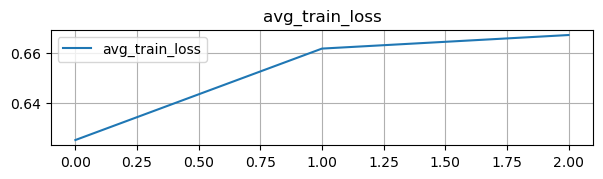

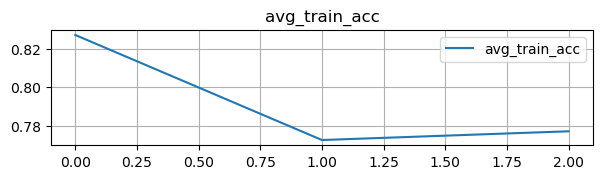

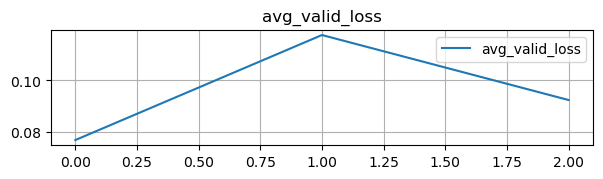

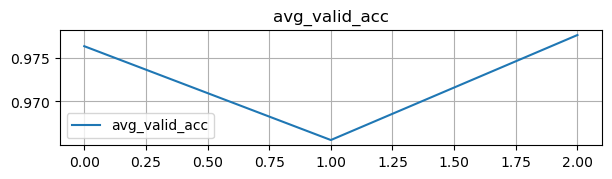

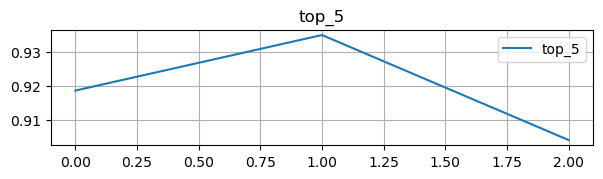

In [29]:
# Как модель обучалась по эпохам? Отрисую
df_train_valid = pd.DataFrame(history, columns = ['avg_train_loss', 
                                                  'avg_train_acc', 
                                                  'avg_valid_loss', 
                                                  'avg_valid_acc', 
                                                  'top_5'])
print(df_train_valid)

for col in df_train_valid.columns:
    df_train_valid[[col]].plot(figsize = (7, 1.5), grid = True, title = col)

In [30]:
# лучшая эпоха и ее качество
df_loss_models = pd.concat([df_loss_models, 
           pd.DataFrame(history[best_epoch], columns = [name_model], 
                        index = ['avg_train_loss', 'avg_train_acc', 'avg_valid_loss', 'avg_valid_acc', 'top_5'])],  
          axis = 1)

df_loss_models

,resnet50
avg_train_loss,0.625437
avg_train_acc,0.827120
avg_valid_loss,0.076731
avg_valid_acc,0.976306
top_5,0.918726


In [31]:
# запишу результаты в дата-фрейм df
df.loc['resnet50', 'top_5'] = df_loss_models.loc['top_5', 'resnet50'] #top_5
df.loc['resnet50', 'params'] = sum(p.numel() for p in resnet50.parameters()) #число параметров

### VGG16. VGG16_Weights.IMAGENET1K_V1

In [32]:
# очищаю cuda
torch.cuda.empty_cache()

In [33]:
# выбираю device
device = get_device('cpu')
device

device(type='cpu')

In [34]:
df_models[df_models['models'].str.contains('VGG16', case = False)]

,models,Weights,Weight,Acc@1,Acc@5,Params,GFLOPS,Recipe,Params_float
96,VGG16_BN,IMAGENET1K_V1,VGG16_BN_Weights.IMAGENET1K_V1,73.360,91.516,138.4M,15.47,link,138.4
97,VGG16,IMAGENET1K_V1,VGG16_Weights.IMAGENET1K_V1,71.592,90.382,138.4M,15.47,link,138.4
98,VGG16,IMAGENET1K_FEATURES,VGG16_Weights.IMAGENET1K_FEATURES,NaN,NaN,138.4M,15.47,link,138.4


In [35]:
#name_model = 'VGG16_Weights.IMAGENET1K_V1'
name_model = 'vgg16'

In [36]:
# Загрузить предварительно обученную модель vgg16 Model
vgg16 = models.vgg16(weights="IMAGENET1K_V1")
vgg16 = vgg16.to(device)

In [37]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
# Заморозить параметры модели
for param in vgg16.parameters():
    param.requires_grad = False

In [39]:
# Изменить последний слой модели vgg16 для трансферного обучения
fc_inputs = vgg16.classifier[0].in_features

vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=fc_inputs, out_features=2048),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=2048),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=num_classes), # число выходов = num_classes
    nn.LogSoftmax(dim=1) # Для инспользования NLLLoss()
)

# Преобразование модели для использования на device
vgg16 = vgg16.to(device)   

In [40]:
fc_inputs

25088

In [41]:
# Определить оптимизатор
optimizer = optim.Adam(vgg16.parameters(),lr=1e-2)

In [42]:
# Обучить модель для num_epochs:
trained_model, history, best_epoch = train_valid(vgg16, loss_func, optimizer, num_epochs)

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:04:16<00:00, 1285.55s/it]


   avg_train_loss  avg_train_acc  avg_valid_loss  avg_valid_acc     top_5
0       10.611424       0.570282        2.435648       0.572994  0.905223
1       13.894710       0.489492        7.758868       0.553885  0.911083
2       20.100620       0.424860        4.596230       0.487134  0.912102


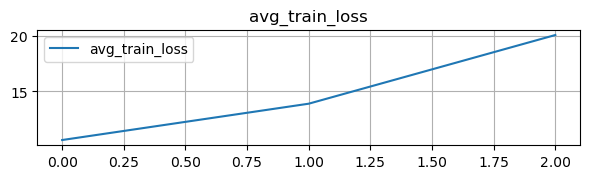

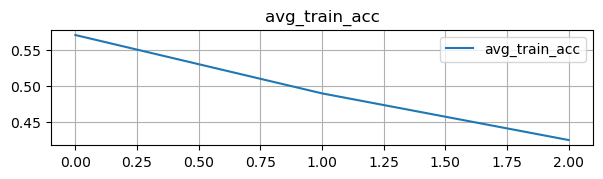

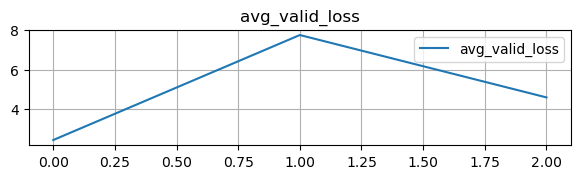

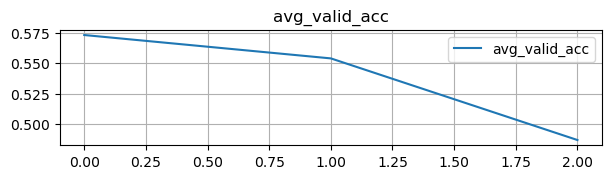

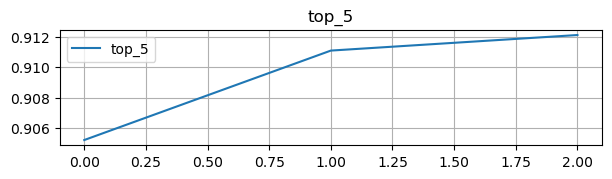

In [43]:
# Как модель обучалась по эпохам? Отрисую
df_train_valid = pd.DataFrame(history, columns = ['avg_train_loss', 
                                                  'avg_train_acc', 
                                                  'avg_valid_loss', 
                                                  'avg_valid_acc', 
                                                  'top_5'])
print(df_train_valid)

for col in df_train_valid.columns:
    df_train_valid[[col]].plot(figsize = (7, 1.5), grid = True, title = col)

In [44]:
# лучшая эпоха и ее качество
df_loss_models = pd.concat([df_loss_models, 
           pd.DataFrame(history[best_epoch], columns = [name_model], 
                        index = ['avg_train_loss', 'avg_train_acc', 'avg_valid_loss', 'avg_valid_acc', 'top_5'])],  
          axis = 1)

df_loss_models

,resnet50,vgg16
avg_train_loss,0.625437,10.611424
avg_train_acc,0.827120,0.570282
avg_valid_loss,0.076731,2.435648
avg_valid_acc,0.976306,0.572994
top_5,0.918726,0.905223


In [45]:
# запишу результаты в дата-фрейм df
df.loc['vgg16', 'top_5'] = df_loss_models.loc['top_5', 'vgg16'] #top_5
df.loc['vgg16', 'params'] = sum(p.numel() for p in vgg16.parameters())

### EfficientNet. EfficientNet_V2_M_Weights.IMAGENET1K_V1

In [46]:
# очищаю cuda
torch.cuda.empty_cache()

In [47]:
# выбираю device
device = get_device('gpu')
device

device(type='cuda', index=0)

In [48]:
df_models[df_models['models'].str.contains('efficientnet', case = False)]

,models,Weights,Weight,Acc@1,Acc@5,Params,GFLOPS,Recipe,Params_float
9,EfficientNet_B0,IMAGENET1K_V1,EfficientNet_B0_Weights.IMAGENET1K_V1,77.692,93.532,5.3M,0.39,link,5.3
10,EfficientNet_B1,IMAGENET1K_V1,EfficientNet_B1_Weights.IMAGENET1K_V1,78.642,94.186,7.8M,0.69,link,7.8
11,EfficientNet_B1,IMAGENET1K_V2,EfficientNet_B1_Weights.IMAGENET1K_V2,79.838,94.934,7.8M,0.69,link,7.8
12,EfficientNet_B2,IMAGENET1K_V1,EfficientNet_B2_Weights.IMAGENET1K_V1,80.608,95.310,9.1M,1.09,link,9.1
13,EfficientNet_B3,IMAGENET1K_V1,EfficientNet_B3_Weights.IMAGENET1K_V1,82.008,96.054,12.2M,1.83,link,12.2
14,EfficientNet_B4,IMAGENET1K_V1,EfficientNet_B4_Weights.IMAGENET1K_V1,83.384,96.594,19.3M,4.39,link,19.3
15,EfficientNet_B5,IMAGENET1K_V1,EfficientNet_B5_Weights.IMAGENET1K_V1,83.444,96.628,30.4M,10.27,link,30.4
16,EfficientNet_B6,IMAGENET1K_V1,EfficientNet_B6_Weights.IMAGENET1K_V1,84.008,96.916,43.0M,19.07,link,43.0
17,EfficientNet_B7,IMAGENET1K_V1,EfficientNet_B7_Weights.IMAGENET1K_V1,84.122,96.908,66.3M,37.75,link,66.3
18,EfficientNet_V2_L,IMAGENET1K_V1,EfficientNet_V2_L_Weights.IMAGENET1K_V1,85.808,97.788,118.5M,56.08,link,118.5


In [49]:
#name_model = 'EfficientNet_V2_M_Weights.IMAGENET1K_V1'
name_model = 'efficientnet'

In [50]:
# Загрузить предварительно обученную модель efficientnet
efficientnet = models.efficientnet.efficientnet_v2_m(weights='IMAGENET1K_V1')
efficientnet = efficientnet.to(device)

In [51]:
efficientnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [52]:
# Заморозить параметры модели
for param in efficientnet.parameters():
    param.requires_grad = False

In [53]:
# Изменить последний слой модели efficientnet для трансферного обучения
fc_inputs = efficientnet.classifier[1].in_features

efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(fc_inputs, out_features=num_classes), # число выходов = num_classes           
    nn.LogSoftmax(dim=1) # Для инспользования NLLLoss()
)

# Преобразование модели для использования на device
efficientnet = efficientnet.to(device)

In [54]:
fc_inputs

1280

In [55]:
# Определить оптимизатор
optimizer = optim.Adam(efficientnet.parameters(),lr=1e-2)

In [56]:
# Обучить модель для num_epochs:
trained_model, history, best_epoch = train_valid(efficientnet, loss_func, optimizer, num_epochs)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:46<00:00, 115.54s/it]


   avg_train_loss  avg_train_acc  avg_valid_loss  avg_valid_acc     top_5
0        0.180769       0.952477        0.065410       0.981401  0.996688
1        0.190250       0.959235        0.097392       0.975287  0.982930
2        0.184591       0.961453        0.107380       0.975541  0.952611


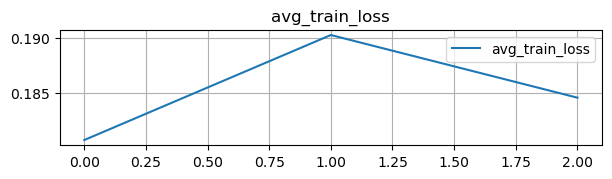

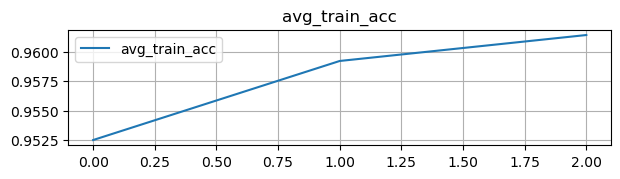

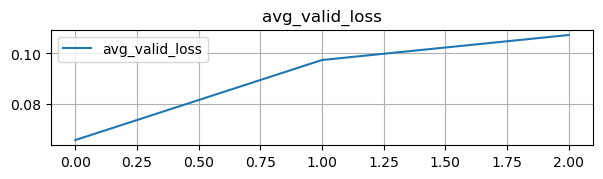

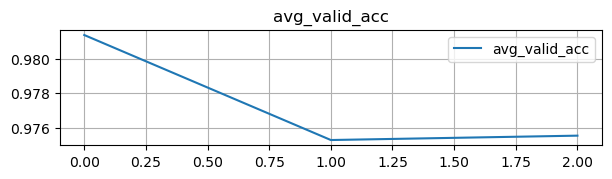

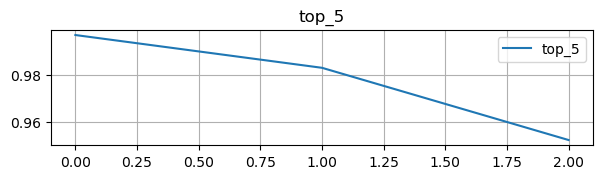

In [57]:
# Как модель обучалась по эпохам? Отрисую
df_train_valid = pd.DataFrame(history, columns = ['avg_train_loss', 
                                                  'avg_train_acc', 
                                                  'avg_valid_loss', 
                                                  'avg_valid_acc', 
                                                  'top_5'])
print(df_train_valid)

for col in df_train_valid.columns:
    df_train_valid[[col]].plot(figsize = (7, 1.5), grid = True, title = col)

In [58]:
# лучшая эпоха и ее качество
df_loss_models = pd.concat([df_loss_models, 
           pd.DataFrame(history[best_epoch], columns = [name_model], 
                        index = ['avg_train_loss', 'avg_train_acc', 'avg_valid_loss', 'avg_valid_acc', 'top_5'])],  
          axis = 1)

df_loss_models

,resnet50,vgg16,efficientnet
avg_train_loss,0.625437,10.611424,0.180769
avg_train_acc,0.827120,0.570282,0.952477
avg_valid_loss,0.076731,2.435648,0.065410
avg_valid_acc,0.976306,0.572994,0.981401
top_5,0.918726,0.905223,0.996688


In [59]:
# запишу результаты в дата-фрейм df
df.loc['efficientnet', 'top_5'] = df_loss_models.loc['top_5', 'efficientnet']
df.loc['efficientnet', 'params'] = sum(p.numel() for p in efficientnet.parameters())

## MobileNet. mobilenet_v2(weights='IMAGENET1K_V1')

In [60]:
# очищаю cuda
torch.cuda.empty_cache()

In [61]:
# выбираю device
device = get_device('gpu')
device

device(type='cuda', index=0)

In [62]:
# смотрю какую модель выбрать
df_models[df_models['models'].str.contains('MobileNet', case = False)]

,models,Weights,Weight,Acc@1,Acc@5,Params,GFLOPS,Recipe,Params_float
28,MobileNet_V2,IMAGENET1K_V1,MobileNet_V2_Weights.IMAGENET1K_V1,71.878,90.286,3.5M,0.30,link,3.5
29,MobileNet_V2,IMAGENET1K_V2,MobileNet_V2_Weights.IMAGENET1K_V2,72.154,90.822,3.5M,0.30,link,3.5
30,MobileNet_V3_Large,IMAGENET1K_V1,MobileNet_V3_Large_Weights.IMAGENET1K_V1,74.042,91.340,5.5M,0.22,link,5.5
31,MobileNet_V3_Large,IMAGENET1K_V2,MobileNet_V3_Large_Weights.IMAGENET1K_V2,75.274,92.566,5.5M,0.22,link,5.5
32,MobileNet_V3_Small,IMAGENET1K_V1,MobileNet_V3_Small_Weights.IMAGENET1K_V1,67.668,87.402,2.5M,0.06,link,2.5


In [63]:
#name_model = 'MobileNet_V2_Weights.IMAGENET1K_V1'
name_model = 'mobilenet'

In [64]:
# Загрузить предварительно обученную модель mobilenet_2
mobilenet_2 = models.mobilenetv2.mobilenet_v2(weights='IMAGENET1K_V1')
mobilenet_2 = mobilenet_2.to(device)

In [65]:
mobilenet_2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [66]:
# Заморозить параметры модели
for param in mobilenet_2.parameters():
    param.requires_grad = False

In [67]:
# Изменить последний слой модели mobilenet_2 для трансферного обучения
fc_inputs = mobilenet_2.classifier[1].in_features

mobilenet_2.classifier = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    #nn.Hardswish(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes), # число выходов = num_classes
    nn.LogSoftmax(dim=1) # Для инспользования NLLLoss()
)

# Преобразование модели для использования на device
mobilenet_2 = mobilenet_2.to(device)

In [68]:
fc_inputs

1280

In [69]:
# Определить оптимизатор
optimizer = optim.Adam(mobilenet_2.parameters(),lr=1e-2)

In [70]:
# Обучите модель для num_epochs:
trained_model, history, best_epoch = train_valid(mobilenet_2, loss_func, optimizer, num_epochs)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.38s/it]


   avg_train_loss  avg_train_acc  avg_valid_loss  avg_valid_acc     top_5
0        1.280248       0.891541        2.019742       0.913376  0.912357
1        3.599080       0.919949        2.857983       0.954140  0.901656
2        3.784405       0.943183        3.900176       0.947516  0.902675


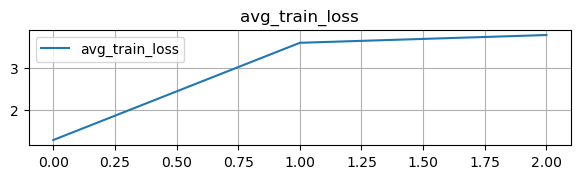

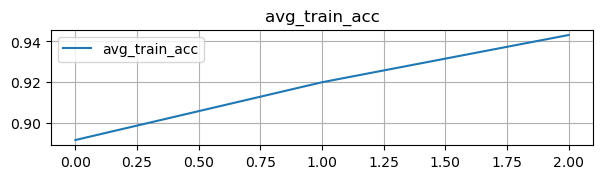

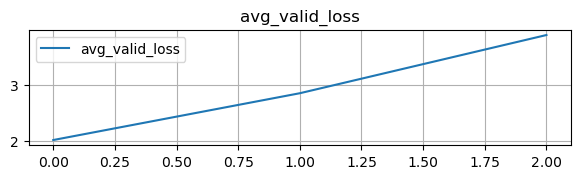

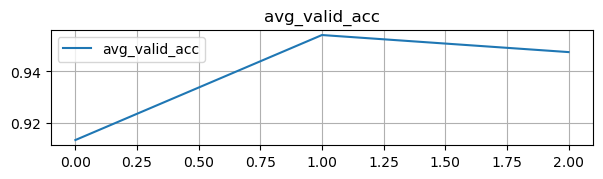

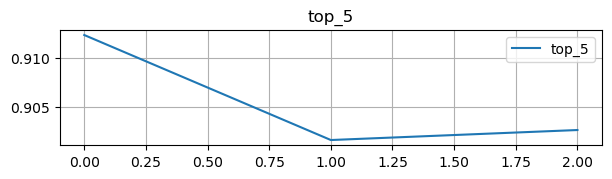

In [71]:
# Как модель обучалась по эпохам? Отрисую
df_train_valid = pd.DataFrame(history, columns = ['avg_train_loss', 
                                                  'avg_train_acc', 
                                                  'avg_valid_loss', 
                                                  'avg_valid_acc', 
                                                  'top_5'])
print(df_train_valid)

for col in df_train_valid.columns:
    df_train_valid[[col]].plot(figsize = (7, 1.5), grid = True, title = col)

In [72]:
# лучшая эпоха и ее качество
df_loss_models = pd.concat([df_loss_models, 
           pd.DataFrame(history[best_epoch], columns = [name_model], 
                        index = ['avg_train_loss', 'avg_train_acc', 'avg_valid_loss', 'avg_valid_acc', 'top_5'])],  
          axis = 1)

df_loss_models

,resnet50,vgg16,efficientnet,mobilenet
avg_train_loss,0.625437,10.611424,0.180769,1.280248
avg_train_acc,0.827120,0.570282,0.952477,0.891541
avg_valid_loss,0.076731,2.435648,0.065410,2.019742
avg_valid_acc,0.976306,0.572994,0.981401,0.913376
top_5,0.918726,0.905223,0.996688,0.912357


In [73]:
# запишу результаты в дата-фрейм df
df.loc['mobilenet', 'top_5'] = df_loss_models.loc['top_5', 'efficientnet']
df.loc['mobilenet', 'params'] = sum(p.numel() for p in mobilenet_2.parameters())

## image_transforms = image_transforms_2

- Inception_v3

In [74]:
# Применение преобразований к данным
image_transforms = {'train': image_transforms_2['train'],
                    'valid': image_transforms_2['valid']}

In [75]:
dir_path_val = pathlib.Path('./imagenette2-160/val/')
dir_path_train = pathlib.Path('./imagenette2-160/train/')      

In [76]:
# Задаю dataset
dataset = 'imagenette2'

In [77]:
# Размер Batch
if num_epochs == 1:
    bs = 8 # для тестирования num_epochs == 1, bs = 8
else: bs = 32 # для чистого num_epochs == 3, bs = 32

# Загрузить данные из папок
data = {
    'train': datasets.ImageFolder(root=dir_path_train, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=dir_path_val, transform=image_transforms['valid']),
}

#Получить сопоставление индексов с именами классов, чтобы увидеть выходные классы тестовых изображений
idx_class = {v: k for k, v in data['train'].class_to_idx.items()}

# Размер данных, которые будут использоваться для расчета средних потерь и точности
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Создать итераторы для данных, загруженных с помощью модуля DataLoader.
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

In [78]:
# Число классов
num_classes = len(idx_class)
print(idx_class)
print(f'Число классов: {num_classes}')

{0: 'n01440764', 1: 'n02102040', 2: 'n02979186', 3: 'n03000684', 4: 'n03028079', 5: 'n03394916', 6: 'n03417042', 7: 'n03425413', 8: 'n03445777', 9: 'n03888257'}
Число классов: 10


In [79]:
print(train_data_size)
print(valid_data_size)

9469
3925


### Inception_v3. Inception_V3_Weights.IMAGENET1K_V1

In [80]:
# очищаю cuda
torch.cuda.empty_cache()

In [81]:
# выбираю device
device = get_device('gpu')
device

device(type='cuda', index=0)

In [82]:
# смотрю какую модель выбрать
df_models[df_models['models'].str.contains('Inception_v3', case = False)]

,models,Weights,Weight,Acc@1,Acc@5,Params,GFLOPS,Recipe,Params_float
22,Inception_V3,IMAGENET1K_V1,Inception_V3_Weights.IMAGENET1K_V1,77.294,93.45,27.2M,5.71,link,27.2


In [83]:
#name_model = 'Inception_V3_Weights.IMAGENET1K_V1'
name_model = 'inception_v3'

In [84]:
# Загрузить предварительно обученную модель inception_v3

inception_v3 = models.inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')
inception_v3 = inception_v3.to(device)

In [85]:
inception_v3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [86]:
# Заморозить параметры модели
inception_v3.aux_logits = False

for parameter in inception_v3.parameters():
    parameter.requires_grad = False

In [87]:
# Изменить последний слой модели inception_v3 для трансферного обучения
fc_inputs = inception_v3.fc.in_features

inception_v3.fc = nn.Sequential(
    nn.Linear(fc_inputs, out_features=num_classes), # число выходов = num_classes
    nn.LogSoftmax(dim=1) # Для инспользования NLLLoss()
)

# Преобразование модели для использования на device
inception_v3 = inception_v3.to(device)

In [88]:
fc_inputs

2048

In [89]:
# Определить оптимизатор
optimizer = optim.Adam(inception_v3.parameters(),lr=1e-2)

In [90]:
# Обучить модель для num_epochs:
trained_model, history, best_epoch = train_valid(inception_v3, loss_func, optimizer, num_epochs)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:19<00:00, 106.47s/it]


   avg_train_loss  avg_train_acc  avg_valid_loss  avg_valid_acc     top_5
0        0.727451       0.846763        0.183822       0.958726  0.997197
1        0.774421       0.872426        0.103179       0.977325  0.921529
2        0.850791       0.879185        0.135287       0.974013  0.936561


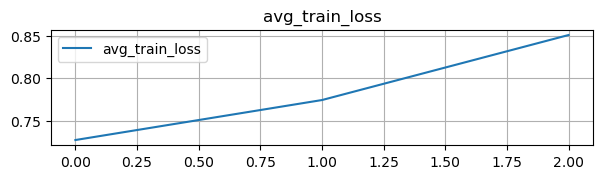

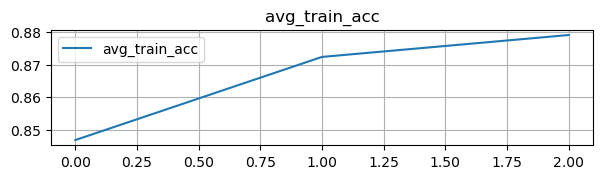

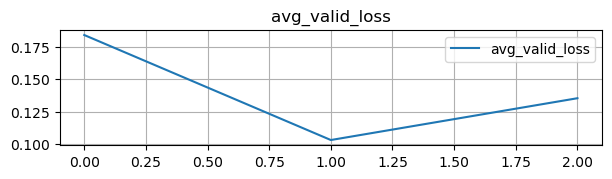

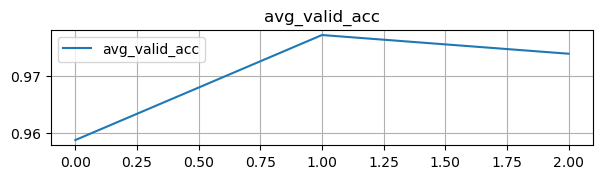

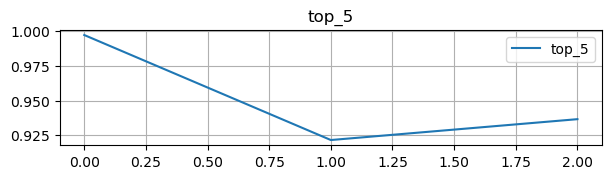

In [91]:
# Как модель обучалась по эпохам? Отрисую
df_train_valid = pd.DataFrame(history, columns = ['avg_train_loss', 
                                                  'avg_train_acc', 
                                                  'avg_valid_loss', 
                                                  'avg_valid_acc', 
                                                  'top_5'])
print(df_train_valid)

for col in df_train_valid.columns:
    df_train_valid[[col]].plot(figsize = (7, 1.5), grid = True, title = col)

In [92]:
# лучшая эпоха и ее качество
df_loss_models = pd.concat([df_loss_models, 
           pd.DataFrame(history[best_epoch], columns = [name_model], 
                        index = ['avg_train_loss', 'avg_train_acc', 'avg_valid_loss', 'avg_valid_acc', 'top_5'])],  
          axis = 1)

df_loss_models

,resnet50,vgg16,efficientnet,mobilenet,inception_v3
avg_train_loss,0.625437,10.611424,0.180769,1.280248,0.774421
avg_train_acc,0.827120,0.570282,0.952477,0.891541,0.872426
avg_valid_loss,0.076731,2.435648,0.065410,2.019742,0.103179
avg_valid_acc,0.976306,0.572994,0.981401,0.913376,0.977325
top_5,0.918726,0.905223,0.996688,0.912357,0.921529


In [93]:
# запишу результаты в дата-фрейм df
df.loc['inception_v3', 'top_5'] = df_loss_models.loc['top_5', 'inception_v3']
df.loc['inception_v3', 'params'] = sum(p.numel() for p in inception_v3.parameters())

# Результат

In [94]:
# df с накопленными результатами 
df

,params,top_5
vgg16,70313802.0,0.905223
inception_v3,25132754.0,0.921529
resnet50,24035146.0,0.918726
mobilenet,2554378.0,0.996688
efficientnet,52871166.0,0.996688


                  params     top_5
vgg16         70313802.0  0.905223
inception_v3  25132754.0  0.921529
resnet50      24035146.0  0.918726
mobilenet      2554378.0  0.996688
efficientnet  52871166.0  0.996688


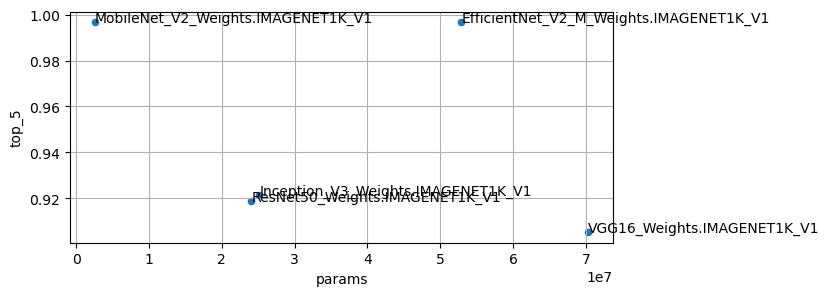

In [95]:
ax = df.plot(kind='scatter', x='params', y = 'top_5', grid = True, figsize = (7,3))
ax.annotate(text='VGG16_Weights.IMAGENET1K_V1', xy=(df.loc[df.index[0]]['params'], df.loc[df.index[0]]['top_5']))
ax.annotate(text='Inception_V3_Weights.IMAGENET1K_V1', xy=(df.loc[df.index[1]]['params'], df.loc[df.index[1]]['top_5']))
ax.annotate(text='ResNet50_Weights.IMAGENET1K_V1', xy=(df.loc[df.index[2]]['params'], df.loc[df.index[2]]['top_5']))
ax.annotate(text='MobileNet_V2_Weights.IMAGENET1K_V1', xy=(df.loc[df.index[3]]['params'], df.loc[df.index[3]]['top_5']))
ax.annotate(text='EfficientNet_V2_M_Weights.IMAGENET1K_V1', xy=(df.loc[df.index[4]]['params'], df.loc[df.index[4]]['top_5']))

print(df)

# Вывод
- Построил график accuracy top 5
- Протестировал cuda, например, vgg16 на gpu (4 gb) не помещается